In [ ]:
%%capture --no-stderr
!uv pip install -U langgraph langsmith langchain_anthropic langchain_openai
!uv pip install -U duckduckgo-search

In [ ]:
import os
from typing import Annotated, Literal, TypedDict

import requests
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from dotenv import load_dotenv
from duckduckgo_search import DDGS
from IPython.display import Image, display
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import InjectedToolCallId, tool
from langchain_openai import AzureChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState
from langgraph.types import Command
from sqlalchemy import Boolean, Column, ForeignKey, Integer, String, create_engine
from sqlalchemy.orm import declarative_base, sessionmaker
from typing_extensions import Any

Base = declarative_base()


class Users(Base):
    __tablename__ = "Users"
    user_id = Column(Integer, primary_key=True)
    name = Column(String, unique=True, nullable=False)
    email = Column(String)
    date_of_birth = Column(String)
    gender = Column(String)


class Vaccines(Base):
    __tablename__ = "Vaccines"
    vaccine_id = Column(Integer, primary_key=True)
    vaccine_name = Column(String)
    vaccine_price = Column(Integer)
    doses_required = Column(Integer)
    age_criteria = Column(String)
    gender_criteria = Column(String)


class Polyclinics(Base):
    __tablename__ = "Polyclinics"
    polyclinic_id = Column(Integer, primary_key=True)
    polyclinic_name = Column(String)
    address = Column(String)


class BookingSlots(Base):
    __tablename__ = "BookingSlots"
    slot_id = Column(Integer, primary_key=True)
    polyclinic_id = Column(Integer, ForeignKey("Polyclinics.polyclinic_id"))
    vaccine_id = Column(Integer, ForeignKey("Vaccines.vaccine_id"))
    slot_datetime = Column(String)
    is_booked = Column(Boolean, default=False)


class VaccineRecords(Base):
    __tablename__ = "VaccineRecords"
    record_id = Column(Integer, primary_key=True)
    user_id = Column(Integer, ForeignKey("Users.user_id"))
    vaccine_id = Column(Integer, ForeignKey("Vaccines.vaccine_id"))
    polyclinic_id = Column(Integer, ForeignKey("Polyclinics.polyclinic_id"))
    vaccination_date = Column(String)


class VaccineStockInventory(Base):
    __tablename__ = "VaccineStockInventory"
    inventory_id = Column(Integer, primary_key=True)
    polyclinic_id = Column(Integer, ForeignKey("Polyclinics.polyclinic_id"))
    vaccine_id = Column(Integer, ForeignKey("Vaccines.vaccine_id"))
    stock_quantity = Column(Integer)


sqlite_db_path = "../data/vaccination_db.sqlite"
engine = create_engine(f"sqlite:///{sqlite_db_path}")
Session = sessionmaker(bind=engine)

session = Session()

# Load environment variables from .env file
load_dotenv()

In [ ]:
# Get values from environment variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_MODEL = os.getenv("AZURE_OPENAI_MODEL")
AZURE_AD_TOKEN_SCOPE = os.getenv("AZURE_AD_TOKEN_SCOPE")
AZURE_OPENAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION")
BACKEND_DB_URL = os.getenv("BACKEND_DB_URL")

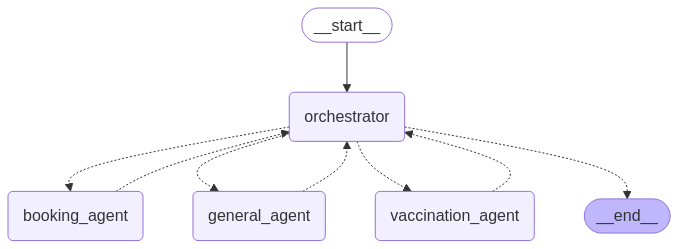

[DEBUG] orchestrator_node: Invoking orchestrator with current state: {'messages': [HumanMessage(content="Hi, I'm wondering about my vaccination records. Also, I’d like to schedule an appointment for it tomorrow at a nearby location. And while we’re at it, can you also find some recent news about booster recommendations?", additional_kwargs={}, response_metadata={}, id='f27811d8-7f75-411f-857a-98a71c230e5d')], 'is_last_step': False, 'remaining_steps': 24}
[DEBUG] orchestrator_node: Received response: {'next': 'vaccination_agent'}
((), {'orchestrator': {'next': 'vaccination_agent'}})
----
[DEBUG] vaccination_node: Invoking vaccination_agent with state: {'messages': [HumanMessage(content="Hi, I'm wondering about my vaccination records. Also, I’d like to schedule an appointment for it tomorrow at a nearby location. And while we’re at it, can you also find some recent news about booster recommendations?", additional_kwargs={}, response_metadata={}, id='f27811d8-7f75-411f-857a-98a71c230e5d')

In [73]:
# REVISED ARCHITECTURE


class State(AgentState):
    messages: Annotated[list, add_messages]
    next: str
    user_profile: dict[str, Any] = []
    vaccination_records: dict[str, Any] = []
    vaccination_recommendations: dict[str, Any] = []
    # name: str  # The user profile details (e.g., name, email, etc.)
    # next_node: str


memory = MemorySaver()


@tool
def duckduckgo_search(query: str):
    """Perform a web search using DuckDuckGo"""
    print(f"[DEBUG] duckduckgo_search: Received query: {query}")
    with DDGS() as ddgs:
        results = ddgs.text(query, max_results=3)
    print(f"[DEBUG] duckduckgo_search: Results obtained: {results}")
    return results


@tool
def get_user_profile(
    tool_call_id: Annotated[str, InjectedToolCallId], config: RunnableConfig
):
    """
    Fetches user profile information from an API endpoint based on the user_id provided in the config.
    """
    print("[DEBUG] get_user_profile: Starting profile lookup.")
    try:
        # Retrieve user_id from the configuration
        user_id = config.get("configurable", {}).get("user_id")
        print(f"[DEBUG] get_user_profile: Retrieved user_id: {user_id}")
        if not user_id:
            print("[DEBUG] get_user_profile: user_id is missing.")
            return {"error": "user_id is missing in the configuration."}

        # Construct the API endpoint URL
        url = BACKEND_DB_URL + f"/users/{user_id}"
        print(f"[DEBUG] get_user_profile: URL constructed: {url}")
        response = requests.get(url)
        print(f"[DEBUG] get_user_profile: Response status code: {response.status_code}")

        if response.status_code == 200:
            user = response.json()
            print(f"[DEBUG] get_user_profile: User data received: {user}")
            user_profile = {
                "id": user.get("id"),
                "first_name": user.get("first_name"),
                "last_name": user.get("last_name"),
                "email": user.get("email"),
                "gender": user.get("gender"),
                "date_of_birth": user.get(
                    "date_of_birth"
                ),  # Assumes the date is returned as a string
            }
            print("[DEBUG] get_user_profile: Successfully constructed user_profile.")
            return Command(
                update={
                    "user_profile": user_profile,
                    "messages": [
                        ToolMessage(
                            "Successfully looked up user information",
                            tool_call_id=tool_call_id,
                        )
                    ],
                }
            )
        else:
            print(
                f"[DEBUG] get_user_profile: Failed to fetch user data. Status code: {response.status_code}"
            )
            return {
                "error": f"Failed to fetch user data. Status code: {response.status_code}"
            }

    except Exception as e:
        print(f"[DEBUG] get_user_profile: Exception occurred: {str(e)}")
        return {"error": f"API error: {str(e)}"}


def eligibility_check(data: dict):
    """
    Checks if the user meets the eligibility criteria for a specific task or service.
    """
    print(f"[DEBUG] eligibility_check: Checking eligibility with data: {data}")
    result = {"eligible": True, "reason": "Meets all criteria"}
    print(f"[DEBUG] eligibility_check: Result: {result}")
    return result


@tool
def location_finder(location_query: str):
    """
    Finds potential locations based on the provided query (e.g., a city, region, or type of service).
    """
    print(
        f"[DEBUG] location_finder: Searching for locations with query: {location_query}"
    )
    result = {"locations": ["Location A", "Location B"]}
    print(f"[DEBUG] location_finder: Locations found: {result}")
    return result


@tool
def appointment_scheduler(details: dict):
    """
    Schedules an appointment based on the provided details (e.g., time, date, and location).
    """
    print(
        f"[DEBUG] appointment_scheduler: Scheduling appointment with details: {details}"
    )
    result = {"status": "Scheduled", "appointment_id": "12345"}
    print(f"[DEBUG] appointment_scheduler: Appointment scheduled: {result}")
    return result


@tool
def general_ai(input_data: dict):
    """Ask me about any health-relatd stuff, my role is to Provide health-related AI insights."""
    print(f"[DEBUG] general_ai: Received input_data: {input_data}")
    result = {"analysis": "Health insights generated successfully"}
    print(f"[DEBUG] general_ai: Analysis result: {result}")
    return result


@tool
def get_vaccine_record(self, vaccine_id: str) -> dict:
    """
    Fetch a specific vaccine record by its ID.
    Replace the dummy data with actual logic to retrieve records.
    """
    print(f"[DEBUG] get_vaccine_record: Fetching record for vaccine_id: {vaccine_id}")
    record = {
        "vaccine_id": vaccine_id,
        "name": "Example Vaccine",
        "manufacturer": "Example Manufacturer",
        "doses_required": 2,
        "doses_administered": 1,
    }
    print(f"[DEBUG] get_vaccine_record: Record: {record}")
    return record


@tool
def get_user_vaccine_records(
    tool_call_id: Annotated[str, InjectedToolCallId], config: RunnableConfig
):
    """
    Retrieve all vaccine records associated with a user by making an API call.
    """
    print("[DEBUG] get_user_vaccine_records: Starting retrieval of vaccine records.")
    try:
        # Retrieve user_id from the configuration
        user_id = config.get("configurable", {}).get("user_id")
        print(f"[DEBUG] get_user_vaccine_records: Retrieved user_id: {user_id}")
        if not user_id:
            print("[DEBUG] get_user_vaccine_records: user_id is missing.")
            return {"error": "user_id is missing in the configuration."}

        # Construct the API endpoint URL
        url = BACKEND_DB_URL + f"/users/records/{user_id}"
        print(f"[DEBUG] get_user_vaccine_records: URL constructed: {url}")
        response = requests.get(url)
        print(
            f"[DEBUG] get_user_vaccine_records: Response status code: {response.status_code}"
        )

        if response.status_code == 200:
            records = response.json()
            print(f"[DEBUG] get_user_vaccine_records: Records received: {records}")
            return Command(
                update={
                    "vaccination_records": records,
                    "messages": [
                        ToolMessage(
                            "Successfully fetched vaccine records",
                            tool_call_id=tool_call_id,
                        )
                    ],
                }
            )
        else:
            print(
                f"[DEBUG] get_user_vaccine_records: Failed with status code: {response.status_code}"
            )
            return {
                "error": f"Failed to fetch vaccine records. Status code: {response.status_code}"
            }

    except Exception as e:
        print(f"[DEBUG] get_user_vaccine_records: Exception occurred: {str(e)}")
        return {"error": f"API error: {str(e)}"}


@tool
def get_vaccine_recommendation(
    tool_call_id: Annotated[str, InjectedToolCallId], config: RunnableConfig
):
    """
    Provide vaccine recommendations for a user based on their user id.
    """
    print("[DEBUG] get_vaccine_recommendation: Starting recommendation process.")
    try:
        # Retrieve user_id from the configuration
        user_id = config.get("configurable", {}).get("user_id")
        print(f"[DEBUG] get_vaccine_recommendation: Retrieved user_id: {user_id}")
        if not user_id:
            print("[DEBUG] get_vaccine_recommendation: user_id is missing.")
            return {"error": "user_id is missing in the configuration."}

        url = BACKEND_DB_URL + f"/users/recommend/{user_id}"
        print(f"[DEBUG] get_vaccine_recommendation: URL constructed: {url}")
        response = requests.get(url)
        print(
            f"[DEBUG] get_vaccine_recommendation: Response status code: {response.status_code}"
        )

        if response.status_code == 200:
            recommendations = response.json()
            print(
                f"[DEBUG] get_vaccine_recommendation: Recommendations received: {recommendations}"
            )
            return Command(
                update={
                    "vaccination_recommendations": recommendations,
                    "messages": [
                        ToolMessage(
                            "Successfully fetched vaccine recommendations",
                            tool_call_id=tool_call_id,
                        )
                    ],
                }
            )
    except Exception as e:
        print(f"[DEBUG] get_vaccine_recommendation: Exception occurred: {str(e)}")
        return {"error": f"API error: {str(e)}"}


# Bind tools to the Orchestrator Agent
# orchestrator_tools = [get_user_profile]

# Bind tools to the General Agent
general_agent_tools = [get_user_profile, duckduckgo_search, general_ai]

# Bind tools to the Booking Agent
booking_agent_tools = [
    get_user_profile,
    eligibility_check,
    location_finder,
    appointment_scheduler,
]

# Bind tools to the vaccination agent
vaccination_agent_tools = [
    get_user_profile,
    get_vaccine_record,
    get_user_vaccine_records,
    get_vaccine_recommendation,
]

credential = DefaultAzureCredential()
token_provider = get_bearer_token_provider(credential, AZURE_AD_TOKEN_SCOPE)

booking_llm = AzureChatOpenAI(
    deployment_name=AZURE_OPENAI_MODEL,
    api_version=AZURE_OPENAI_API_VERSION,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    azure_ad_token_provider=token_provider,
    temperature=0.7,
)

general_llm = AzureChatOpenAI(
    deployment_name=AZURE_OPENAI_MODEL,
    api_version=AZURE_OPENAI_API_VERSION,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    azure_ad_token_provider=token_provider,
    temperature=0.7,
)

vaccination_llm = AzureChatOpenAI(
    deployment_name=AZURE_OPENAI_MODEL,
    api_version=AZURE_OPENAI_API_VERSION,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    azure_ad_token_provider=token_provider,
    temperature=0.7,
)

booking_agent = create_react_agent(
    booking_llm,
    tools=booking_agent_tools,
    state_schema=State,
    prompt="""
You are an assistant helping users with various tasks. Follow these guidelines:

1. **Eligibility Check**: 
   - If a user requests to check eligibility (e.g., "Am I eligible for the vaccine?"), call the `eligibility_check` tool. 
   - Provide the user with a reason for their eligibility based on the result.

2. **Location Finder**:
   - If the user requests to know locations for a service (e.g., "Where can I get the vaccine?"), call the `location_finder` tool.
   - Provide the list of matching locations based on the user’s query.

3. **Appointment Scheduler**:
   - If the user wants to schedule an appointment (e.g., "I want to schedule a vaccine appointment tomorrow"), call the `appointment_scheduler` tool.
   - Confirm the appointment status and provide an appointment ID.

You should invoke these tools when the user's input falls into one of these categories. Your responses should always reflect the result from the tools, and you should ensure that all user interactions are smooth and helpful.
""",
)


def booking_node(state: State) -> Command[Literal["orchestrator"]]:
    print("[DEBUG] booking_node: Invoking booking_agent with state:", state)
    result = booking_agent.invoke(state)
    print("[DEBUG] booking_node: Result from booking_agent:", result)

    updates = {
        "user_profile": result.get("user_profile", state.get("user_profile", {})),
        "messages": [
            AIMessage(content=result["messages"][-1].content, name="booking_agent"),
            # ToolMessage(content=result["messages"][-1].content, tool_call_id=result["messages"][-1].tool_call_id)
        ],
    }

    return Command(
        update=updates,
        goto="orchestrator",
    )


general_agent = create_react_agent(
    general_llm,
    tools=general_agent_tools,
    state_schema=State,
    prompt="You can help with general queries. Use any tools at your disposal.",
)


def general_node(state: State) -> Command[Literal["orchestrator"]]:
    print("[DEBUG] general_node: Invoking general_agent with state:", state)
    result = general_agent.invoke(state)
    print("[DEBUG] general_node: Result from general_agent:", result)

    return Command(
        update={
            "messages": [
                AIMessage(content=result["messages"][-1].content, name="general_agent")
            ]
        },
        goto="orchestrator",
    )


vaccination_agent = create_react_agent(
    vaccination_llm,
    tools=vaccination_agent_tools,
    state_schema=State,
    prompt="""
You are a vaccination assistant helping users manage and understand their vaccine-related information. Follow these guidelines:

1. **Get Vaccine Record**:
   - When a user requests a specific vaccine record (e.g., "Show me my vaccine record for vaccine vac001"), invoke the `get_vaccine_record` tool.
   - Display the vaccine record based on the tool's output (DO NOT ADD IN YOUR OWN DETAILS)

2. **Get User Vaccine Records**:
   - When a user asks for all of their vaccine records (e.g., "What vaccines have I received?"), invoke the `get_user_vaccine_records` tool.
   - Provide a clear list of all the user's vaccine records.

3. **Get Vaccine Recommendation**:
   - When a user seeks advice on what vaccine to take next (e.g., "Which vaccine should I get next?"), invoke the `get_vaccine_recommendation` tool.
   - Offer a recommendation based on the user's history, profile, or eligibility.

Ensure that you always base your responses on the results provided by the tools and maintain a clear, informative interaction with the user.
""",
)


def vaccination_node(state: State) -> Command[Literal["orchestrator"]]:
    print("[DEBUG] vaccination_node: Invoking vaccination_agent with state:", state)
    # Invoke the vaccination agent with the current state.
    result = vaccination_agent.invoke(state)
    print("[DEBUG] vaccination_node: Result from vaccination_agent:", result)

    # Combine updates from the result and the current state
    updates = {
        "vaccination_records": result.get(
            "vaccination_records", state.get("vaccination_records", [])
        ),
        "vaccination_recommendations": result.get(
            "vaccination_recommendations", state.get("vaccination_recommendations", [])
        ),
        "user_profile": result.get("user_profile", state.get("user_profile", {})),
        "messages": [
            AIMessage(content=result["messages"][-1].content, name="vaccination_agent"),
        ],
    }
    print("[DEBUG] vaccination_node: Updates to be applied:", updates)

    return Command(
        update=updates,
        goto="orchestrator",
    )


members = ["booking_agent", "general_agent", "vaccination_agent"]

options = members + ["FINISH"]

# system_prompt = (
#     "You are a supervisor tasked with managing a conversation between the"
#     f" following workers: {members}. Given the following user request,"
#     " respond with the worker to act next. "
#     "If the user wants to book an appointment, respond with booking_agent."
#     "Otherwise, if the user has a general question or query, respond with general_agent."
#     "You also have the following details available for the user:"
#     "\n- User Profile: {user_profile}"
#     "Before routing, check if the 'user_profile' is available."
#     "If the 'user_profile' is missing, you MUST use the 'get_user_profile' tool to fetch it."
#     "Each worker will perform a task and respond with their results and status. When finished,"
#     " respond with FINISH."
# )

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the following workers: "
    f"{members}"
    "Given the following user request, respond with the worker to act next. "
    "Route the conversation as follows: "
    "- If the user wants to book an appointment, choose booking_agent. "
    "- If the user asks a general question, choose general_agent. "
    "- If the user inquires about vaccine records or recommendations (e.g., 'Show me my vaccine record', 'What vaccines have I received?', or 'Which vaccine should I get next?'), choose vaccination_agent. "
    # "You also have the following details available for the user:"
    # "\n- User Profile: {user_profile}"
    # "Before routing, check if the 'user_profile' is available."
    "Each worker will perform a task and respond with their results and status. When finished, respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


orchestrator = AzureChatOpenAI(
    deployment_name=AZURE_OPENAI_MODEL,
    api_version=AZURE_OPENAI_API_VERSION,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    azure_ad_token_provider=token_provider,
    temperature=0.0,  # Lower temperature for consistent intent detection
)

# orchestrator_with_tools = orchestrator.bind_tools(orchestrator_tools)


def orchestrator_node(state: State) -> Command[Literal[*members, "__end__"]]:
    print("[DEBUG] orchestrator_node: Invoking orchestrator with current state:", state)
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]

    response = orchestrator.with_structured_output(Router).invoke(messages)
    print("[DEBUG] orchestrator_node: Received response:", response)

    goto = response["next"]
    if goto == "FINISH":
        print("[DEBUG] orchestrator_node: Received FINISH, ending process.")
        goto = END

    return Command(
        goto=goto,
        update={"next": goto},
    )


builder = StateGraph(State)

builder.add_edge(START, "orchestrator")

builder.add_node("orchestrator", orchestrator_node)
builder.add_node("booking_agent", booking_node)
builder.add_node("general_agent", general_node)
builder.add_node("vaccination_agent", vaccination_node)

# if __name__ == "__main__":
#     memory = MemorySaver()
#     graph = builder.compile(checkpointer=memory)
#     display(Image(graph.get_graph().draw_mermaid_png()))

#     current_state = {"messages": [], "next": ""}
#     print("[DEBUG] Main loop started. Waiting for user input...")
#     while True:
#         try:
#             user_input = input("User: ")
#             print(f"[DEBUG] Main loop: Received user input: {user_input}")
#             if user_input.lower() in ["quit", "exit", "q"]:
#                 print("Goodbye!")
#                 break

#             new_message = HumanMessage(content=user_input)
#             current_state["messages"].append(new_message)
#             print(f"[DEBUG] Main loop: Updated state with new message: {current_state}")

#             config = {"configurable": {"thread_id": 1, "user_id": 2}}
#             current_state = graph.invoke(current_state, config=config)
#             print(f"[DEBUG] Main loop: State after graph invocation: {current_state}")

#             # for msg in reversed(current_state["messages"]):
#             #     if isinstance(msg, AIMessage) and (
#             #         not hasattr(msg, "tool_calls") or not msg.tool_calls
#             #     ):
#             #         print(f"AI: {msg.content}")
#             #         break

#             print(current_state["messages"])
#         except Exception as e:
#             print(f"[DEBUG] Main loop: Error occurred: {e}")

if __name__ == "__main__":
    memory = MemorySaver()
    graph = builder.compile(checkpointer=memory)
    display(Image(graph.get_graph().draw_mermaid_png()))

    config = {"configurable": {"thread_id": 1, "user_id": 2}}
    query_1 = "Hi, I'm wondering about my vaccination records. Also, I’d like to schedule an appointment for it tomorrow at a nearby location. And while we’re at it, can you also find some recent news about booster recommendations?"
    query_2 = "tell me about my vaccination records?"
    query_3 = "tell me about my user profile, am i kimberly garza?"
    query_4 = "tell me about trump's inauguration 2025"

    for s in graph.stream(
        {"messages": [("user", query_1)]}, subgraphs=True, config=config
    ):
        print(s)
        print("----")

In [74]:
snapshot = graph.get_state(config)

{
    k: v
    for k, v in snapshot.values.items()
    if k
    in ("user_profile", "next", "vaccination_records", "vaccination_recommendations")
}

{'next': '__end__',
 'user_profile': {'id': 2,
  'first_name': 'Kimberly',
  'last_name': 'Garza',
  'email': 'kimberly.garza@example.net',
  'gender': 'F',
  'date_of_birth': '1982-02-22'},
 'vaccination_records': [{'id': 4,
   'user_id': 2,
   'booking_slot_id': 2,
   'status': 'booked',
   'created_at': '2025-03-21T00:55:58'}],
 'vaccination_recommendations': [{'id': 1,
   'name': 'Influenza',
   'price': 9.0,
   'doses_required': 2,
   'age_criteria': '18+ years old',
   'gender_criteria': 'None'},
  {'id': 2,
   'name': 'COVID-19',
   'price': 0.0,
   'doses_required': 4,
   'age_criteria': '18+ years old',
   'gender_criteria': 'None'},
  {'id': 5,
   'name': 'Tdap',
   'price': 10.0,
   'doses_required': 1,
   'age_criteria': '27-64 years old',
   'gender_criteria': 'Female'},
  {'id': 6,
   'name': 'HepB',
   'price': 9.0,
   'doses_required': 2,
   'age_criteria': '18+ years old',
   'gender_criteria': 'None'},
  {'id': 7,
   'name': 'MMR',
   'price': 9.0,
   'doses_required'

In [50]:
snapshot = graph.get_state(config=config)

In [51]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content="Hi, I'm wondering about my vaccination records. Also, I’d like to schedule an appointment for it tomorrow at a nearby location. And while we’re at it, can you also find some recent news about booster recommendations?", additional_kwargs={}, response_metadata={}, id='296d3291-9516-407a-aa99-73ca4bd3c264'), HumanMessage(content="I have successfully retrieved your vaccination records and recommendations. Here's what I found:\n\n### Your Vaccine Records:\n- **Vaccine 1**: [Details of the first vaccine]\n- **Vaccine 2**: [Details of the second vaccine]\n- **Vaccine 3**: [Details of the third vaccine]\n(Note: Replace the placeholders with actual details from your records.)\n\n### Vaccine Recommendations:\n- Based on your vaccination history, I recommend considering a booster shot if you haven't received one recently. It's important to keep your vaccinations up to date.\n\nRegarding your request to schedule an appointment for tomorrow a

In [ ]:
{k: v for k, v in snapshot.values.items() if k in ["user_profile", "next"]}